# Scientific Notebook: Fairness Analysis on Bogota Crime Data

## Purpose
This notebook is designed to perform a fairness analysis on crime prediction models using pre-processed Bogota crime data and defined protected/unprotected regions. It focuses on loading model predictions and real data, applying fairness metrics, and analyzing the results to understand potential disparities in predictive performance across different areas of the city.

## Workflow Stage
This notebook is in the Evaluation / Fairness Analysis stage. It takes the outputs (predictions and real data) from previous modeling notebooks and evaluates their fairness characteristics based on predefined spatial regions.

## About
This notebook utilizes processed Bogota crime data and model outputs to assess the fairness of crime predictions. It involves loading spatial masks, prediction and real data grids, and applying relevant fairness measures to quantify performance differences between protected and unprotected areas.


### 1. Initial Setup, Library Imports, and Path Configuration
This block performs initial setup, including importing libraries for data handling, geospatial operations, prediction models (open_cp), metrics (sklearn), and utilities. It conditionally mounts Google Drive and defines project-specific paths based on the execution environment (Colab or local), adding them to the system path. Finally, it conditionally changes the current working directory to the Bogota data location.

In [ ]:
# Import necessary libraries
import geopandas as gpd # For working with geospatial data
import pandas as pd # For data manipulation and analysis
import numpy as np # For numerical operations
import random # For random number generation (if used later)
import sys, os.path, os # For system and path operations
from tqdm import tqdm # For progress bars
import pickle as pkl # For loading/saving Python objects
from shapely.geometry import Point,Polygon # For geometric objects
import dateutil.parser # For parsing dates
from sklearn import metrics # For evaluation metrics (e.g., AUC)
#import panel as pn # Commented out import, possibly for interactive dashboards

# Import modules from datetime for date/time handling
from datetime import datetime, timedelta

# Conditional setup for Google Colab or local environment
# Handles mounting Google Drive and defining project paths based on environment
try:
    # Attempt to import drive from google.colab (runs in Colab)
    from google.colab import drive
    # Mount Google Drive to access files
    drive.mount('/content/drive')

    # Define paths relative to the mounted Google Drive
    # These paths point to directories containing custom libraries/scripts.
    path_opencp="drive/Shareddrives/FAIRNESS/Colab/Librerias/PredictCode/"
    path_fairness="drive/Shareddrives/FAIRNESS/Colab/Librerias/"
    path_exp="drive/Shareddrives/FAIRNESS/Colab/Notebooks_for_topic/EXP0/SCRIPTS/"

except:
    # If in a local environment (Colab import fails), define paths using local file system structure
    # NOTE: These paths need to be adjusted according to your local Google Drive sync or file structure.
    path_opencp="/Users/diegohernandez/Google Drive/Unidades compartidas/FAIRNESS/Colab/Librerias/PredictCode/"
    path_fairness="/Users/diegohernandez/Google Drive/Unidades compartidas/FAIRNESS/Colab/Librerias/"
    path_exp="/Users/diegohernandez/Google Drive/Unidades compartidas/FAIRNESS/Colab/Notebooks_for_topic/EXP0/SCRIPTS/"


# Add the defined paths to the Python system path
# This allows importing modules directly from these directories.
sys.path.insert(0, os.path.abspath(path_opencp))
sys.path.insert(0, os.path.abspath(path_fairness))
sys.path.insert(0, os.path.abspath(path_exp))

# Import additional libraries after paths are set (potentially custom ones)
import open_cp # Custom library, likely for spatio-temporal analysis/prediction
import open_cp.geometry # Geometry module from open_cp
import matplotlib.pyplot as plt # For plotting

# Conditionally change the current working directory
# This sets the base directory for subsequent file operations (e.g., loading data files).
# It attempts the Colab path first, then falls back to a local path if the first fails.
# NOTE: These paths must exist and be correct for your environment.
try:
    # Change directory to the Bogota data folder (Colab path)
    os.chdir("drive/Shareddrives/FAIRNESS/Colab/Notebooks_for_topic/EXP0/DATOS/BOGOTA")
except:
    # Change directory to the Bogota data folder (Local path fallback)
    os.chdir("/Users/diegohernandez/Google Drive/Unidades compartidas/FAIRNESS/Colab/Notebooks_for_topic/EXP0/DATOS/BOGOTA")
    None # 'None' here does nothing if chdir fails in the except block; error would still occur if local path also fails.

Failed to import `rtree`.


### 2. Define Utility Functions and Load Spatial Masks
This block defines a utility function plot_intensity for visualizing spatial intensity grids and imports the Earth Mover's Distance (EMD) function. It then loads various spatial mask and region objects (grid, locality mask, protected/unprotected/zero masks) that were previously created and saved. Finally, it performs some initial checks or calculations on the loaded masks.

In [ ]:
# Define a utility function to plot spatial intensity grids.
# Takes a 2D numpy array 'intensity' and visualizes it using matplotlib.
def plot_intensity(intensity):
    # Create a figure and axes for the plot.
    fig, ax = plt.subplots(figsize=(11,5))
    # Display the intensity matrix as an image using the 'jet' colormap.
    # interpolation='none' prevents interpolation between pixels. alpha sets transparency. vmin=0 sets minimum color value.
    im=ax.imshow(intensity, 'jet', interpolation='none', alpha=0.7,vmin=0)
    # Invert the y-axis to match typical image/grid coordinates (origin top-left).
    ax.invert_yaxis()
    # Add a color bar to the plot to show the mapping of values to colors.
    plt.colorbar(im)
    # Display the plot.
    plt.show(ax)

# Import the Earth Mover's Distance (EMD) function from scipy.stats, aliasing it as emd.
from scipy.stats import wasserstein_distance as emd

# Load previously saved spatial objects from pickle files.
# These files contain the defined region and various grid masks.
# Paths are relative to the current working directory.
region=pkl.load(open('definition_region.pkl', "rb")) # Load the rectangular region object
mask=pkl.load(open('mascara_localidades.pkl', "rb")) # Load the locality mask array (with locality codes)
mask_protegidos=pkl.load(open('mascara_protegidos.pkl', "rb")) # Load the boolean mask for protected regions
mask_noprotegidos=pkl.load(open('mascara_noprotegidos.pkl', "rb")) # Load the boolean mask for non-protected regions
mask_zeros=pkl.load(open('mascara_zeros.pkl', "rb")) # Load the boolean mask for zero-coded regions

# Create a dictionary to store the protected and non-protected boolean masks.
total_mask={"p":mask_protegidos,"n_p":mask_noprotegidos}

# Access and potentially display the second row of the protected mask (implicit output).
mask_protegidos[1]

# Calculate 1% of the total number of cells in the protected mask and cast to integer (implicit output).
# This value might be used later for calculations or thresholds.
int(np.sum(mask_protegidos)*0.01)


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False])

### 3. Visualize Spatial Masks
This block uses the plot_intensity function defined in the previous cell to visualize the boolean masks for protected and non-protected regions, as well as the original locality mask. This allows for visual inspection of the spatial distribution of these defined areas.

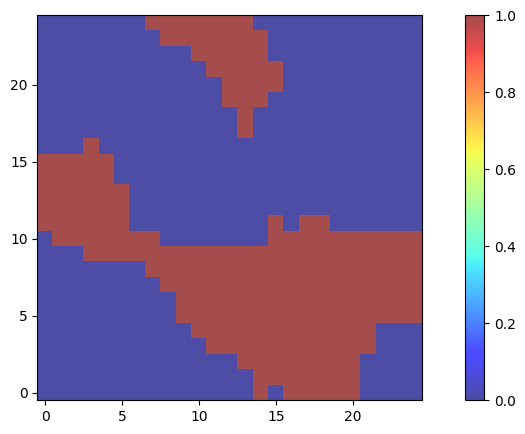

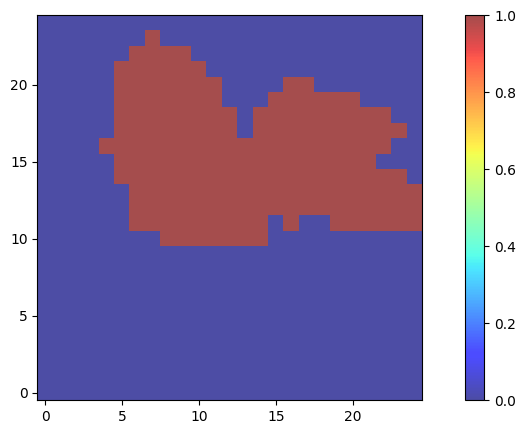

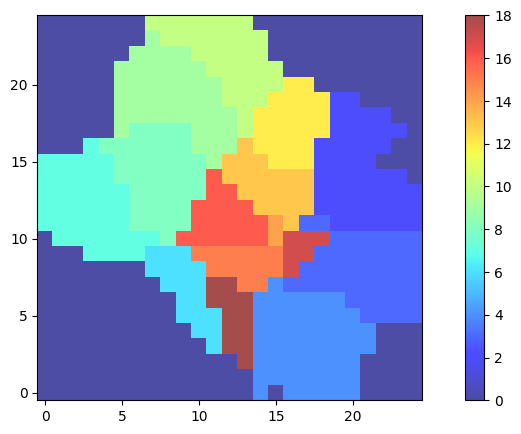

In [ ]:
# Use the plot_intensity function to visualize the protected, non-protected, and locality masks.
# The masks are assumed to be loaded in the previous cell.
plot_intensity(mask_protegidos)   # Visualize the boolean mask for protected regions
plot_intensity(mask_noprotegidos) # Visualize the boolean mask for non-protected regions
plot_intensity(mask)              # Visualize the locality mask (with locality codes)


### 4. Load Model Predictions and Real Data
This block loads the previously generated prediction and real data dictionaries for the Naive, KDE, and SEPP models from their respective pickle files. It stores these loaded dictionaries in a nested dictionary structure (DATA) for easy access and also extracts the prediction dates from the Naive model predictions.

In [ ]:
# Load prediction and real data for each model from pickle files.
# The paths are relative to the current working directory.
# NOTE: Ensure the 'NAIVE/', 'KDE/', and 'SEPP/' directories and the respective pickle files exist.
DATA={
    "Naive":{
        "predictions":pkl.load(open('NAIVE/predictions_window.pkl', "rb")),
        "reals":pkl.load(open('NAIVE/reals_window.pkl', "rb"))
    },
    "KDE":{
        "predictions":pkl.load(open('KDE/predictions_window.pkl', "rb")),
        "reals":pkl.load(open('KDE/reals_window.pkl', "rb"))
    },
    "SEPP":{
        "predictions":pkl.load(open('SEPP/predictions_window.pkl', "rb")),
        "reals":pkl.load(open('SEPP/reals_window.pkl', "rb"))
    }
}

#[len(DATA["SEPP"]["predictions"].keys()),] # Commented out line
# Extract the keys (which are the prediction dates) from the Naive model predictions dictionary.
# Assuming all models were run for the same set of dates.
days=DATA["Naive"]["predictions"].keys()


### 5. Calculate and Store Fairness Metrics
This block imports fairness measure functions and initializes a DataFrame to store results. It then iterates through each prediction date and each model (Naive, KDE, SEPP), calculates fairness metrics (Benefit at K-most predicted cells for protected/unprotected areas and Earth Mover's Distance) for varying percentages of predicted area, and appends the results to the DataFrame. Finally, the DataFrame is saved to a TSV file.

In [ ]:
# Import necessary fairness measure functions and utilities.
# f_benefit_k_most calculates the "Benefit" metric at the k-most predicted cells.
from fairness_measures.measures_2 import f_benefit, f_benefit_k_most
from fairness_measures import utils, measures_2

# Commented out: Lists of fairness measure types and names (unused in this snippet).
# fairness_type=[measures_2.MM,measures_2.gini_coeff]
# fairness_name=["Maxmin","Gini"]

# List of names for protected and non-protected groups (unused in this snippet).
protected_names=["Protected","No_Protected"]

# Comment indicating the purpose: Fairness percentage area

# Initialize an empty pandas DataFrame to store the calculated fairness results.
# Define columns for Model, Percentage of area, Date, Population group, Confusion Matrix components (as 'Confusion_Matrix'), Precision, Accuracy, and EMD.
Fairness_table=pd.DataFrame(columns=["Model","Percentage","Dia","Population","Confusion_Matrix","Precision","Accuracy","EMD"])

# Iterate through each prediction date ('dia') in the 'days' sequence (defined in a previous cell).
for dia in tqdm(days): # tqdm provides a progress bar

    # Iterate through each model name.
    for model in ["Naive","KDE","SEPP"]:
    #for model in ["SEPP"]: # Commented out: Loop only for SEPP model

       #if model=="SEPP": # Commented out: Conditional date conversion (handled below)
       #     dia=dia.date()

        # Iterate through different percentages 'p' of the total area (from 0.01 to 0.3 with steps of 0.005).
        for p in np.arange(0.01,0.3,0.005):

            # Calculate the number of cells corresponding to the current percentage 'p' for protected and non-protected areas.
            # total_mask is assumed to be defined in a previous cell (cell 2).
            number_cells_p=int(np.sum(total_mask["p"])*p)
            number_cells_up=int(np.sum(total_mask["n_p"])*p)

            # Skip if the number of protected cells is zero for this percentage.
            if number_cells_p<=0:
                continue

            # Calculate fairness metrics (Benefit, Precision, Accuracy) for the protected area.
            # Uses the f_benefit_k_most function with the protected mask, real data, prediction data, and number of cells.
            # DATA[model]["reals"][dia] and DATA[model]["predictions"][dia] are the real and predicted intensity grids for the current date and model.
            B_protected,precision_p,accuracy_p=f_benefit_k_most(total_mask["p"],DATA[model]["reals"][dia],DATA[model]["predictions"][dia],number_cells_p)

            # Calculate fairness metrics for the non-protected area using the corresponding mask and number of cells.
            B_no_protected,precision_no_p,accuracy_no_p=f_benefit_k_most(total_mask["n_p"],DATA[model]["reals"][dia],DATA[model]["predictions"][dia],number_cells_up)

            # Calculate the Earth Mover's Distance (EMD) between the flattened real and predicted intensity grids for the whole region.
            EMD_value=emd(DATA[model]["reals"][dia].flatten(),DATA[model]["predictions"][dia].flatten())

            # Append the calculated metrics for both protected and unprotected populations to the Fairness_table DataFrame.
            # Loop through a list containing information for protected and unprotected populations.
            for population in [["Protected",B_protected,precision_p,accuracy_p],["Unprotected",B_no_protected,precision_no_p,accuracy_no_p]]:
                # Append a new row to the DataFrame using .loc[len(Fairness_table)].
                # Conditionally format the date ('dia') based on the model (SEPP uses datetime, others might use date only).
                if model=="SEPP":
                    Fairness_table.loc[len(Fairness_table)]=[model,p,dia,population[0],population[1],population[2],population[3],EMD_value]
                else:
                    Fairness_table.loc[len(Fairness_table)]=[model,p,dia.date(),population[0],population[1],population[2],population[3],EMD_value]

#Fairness_table['tipo_fairness'] = Fairness_table['tipo_fairness'].str.replace('Maxmin', 'Max-Min') # Commented out line

# Save the final Fairness_table DataFrame to a TSV file.
# The path is relative to the current working directory.
# sep='\t' specifies tab as the delimiter.
# NOTE: Ensure the target directory is writable.
Fairness_table.to_csv('Fairness_Results_Bogota.tsv',sep='\t')


  0%|          | 0/442 [00:00<?, ?it/s]

/Users/diegohernandez/Google Drive/Unidades compartidas/FAIRNESS/Colab/Librerias/fairness_measures/measures_2.py:35: RuntimeWarning: invalid value encountered in divide
  real_events=real_events/real_events.sum()
/Users/diegohernandez/Google Drive/Unidades compartidas/FAIRNESS/Colab/Librerias/fairness_measures/measures_2.py:35: RuntimeWarning: invalid value encountered in divide
  real_events=real_events/real_events.sum()
/Users/diegohernandez/Google Drive/Unidades compartidas/FAIRNESS/Colab/Librerias/fairness_measures/measures_2.py:35: RuntimeWarning: invalid value encountered in divide
  real_events=real_events/real_events.sum()
/Users/diegohernandez/Google Drive/Unidades compartidas/FAIRNESS/Colab/Librerias/fairness_measures/measures_2.py:35: RuntimeWarning: invalid value encountered in divide
  real_events=real_events/real_events.sum()
/Users/diegohernandez/Google Drive/Unidades compartidas/FAIRNESS/Colab/Librerias/fairness_measures/measures_2.py:35: RuntimeWarning: invalid value e

KeyboardInterrupt: 

### 6. Load, Clean, and Query Fairness Results
This block loads the fairness results DataFrame that was saved in the previous step. It then cleans the 'Dia' column by removing the time component and standardizes the 'Population' column names. Finally, it performs a preliminary query on the DataFrame to filter results based on 'Percentage' and 'Precision' values.

In [ ]:
# Load the fairness results DataFrame from the TSV file.
# The path is relative to the current working directory.
Fairness_table=pd.read_csv('Fairness_Results_Bogota.tsv',sep='\t')

# Clean the 'Dia' column: split the string by space and take the first part (date only).
Fairness_table['Dia']=Fairness_table['Dia'].apply(lambda x: x.split(" ")[0])
# Clean and standardize the 'Population' column: replace 'Protected' with 'Group 1' and 'Unprotected' with 'Group 2'.
Fairness_table['Population']=Fairness_table['Population'].apply(lambda x: 'Group 1' if x=='Protected' else 'Group 2')

# Query the DataFrame to filter rows where 'Percentage' is 0.15 and 'Precision' is greater than or equal to 0.7.
# Display the result of the query (implicit output).
Fairness_table.query("Percentage==0.15 and Precision>=0.7")


,Unnamed: 0,Model,Percentage,Dia,Population,Confusion_Matrix,Precision,Accuracy,EMD
44021,44021,KDE,0.15,2018-10-05,Group 2,[[19 8]\n [ 0 0]],0.703704,0.703704,0.001882
58753,58753,SEPP,0.15,2018-11-16,Group 2,[[20 7]\n [ 0 0]],0.740741,0.740741,0.001200
85201,85201,SEPP,0.15,2019-03-02,Group 2,[[20 7]\n [ 0 0]],0.740741,0.740741,0.001106
111997,111997,SEPP,0.15,2019-06-17,Group 2,[[20 7]\n [ 0 0]],0.740741,0.740741,0.001380
137401,137401,SEPP,0.15,2019-09-28,Group 2,[[20 7]\n [ 0 0]],0.740741,0.740741,0.001533
142737,142737,Naive,0.15,2019-11-29,Group 2,[[19 8]\n [ 0 0]],0.703704,0.703704,0.001977
144477,144477,Naive,0.15,2019-12-04,Group 2,[[19 8]\n [ 0 0]],0.703704,0.703704,0.002061


In [9]:
#Fairness_table.head()
Fairness_table.query("(Dia>='2018-11-16' and Dia<'2018-11-17') and Percentage==0.15")

,Unnamed: 0,Model,Percentage,Dia,Population,Confusion_Matrix,Precision,Accuracy,EMD
58520,58520,Naive,0.15,2018-11-16,Group 1,[[12 20]\n [ 0 0]],0.375000,0.375000,0.001755
58521,58521,Naive,0.15,2018-11-16,Group 2,[[16 11]\n [ 0 0]],0.592593,0.592593,0.001755
58636,58636,KDE,0.15,2018-11-16,Group 1,[[13 19]\n [ 0 0]],0.406250,0.406250,0.001730
58637,58637,KDE,0.15,2018-11-16,Group 2,[[14 13]\n [ 0 0]],0.518519,0.518519,0.001730
58752,58752,SEPP,0.15,2018-11-16,Group 1,[[12 20]\n [ 0 0]],0.375000,0.375000,0.001200
58753,58753,SEPP,0.15,2018-11-16,Group 2,[[20 7]\n [ 0 0]],0.740741,0.740741,0.001200


### 7. Prepare Spatial Data for Visualization
This block prepares spatial data for visualization and analysis for a specific date across different models (Naive, KDE, SEPP). It loads the grid, assigns protected/unprotected region indicators, and incorporates the prediction and real event intensity values for the chosen date into the grid GeoDataFrame. It saves these enhanced grid GeoDataFrames for each model. Additionally, it loads and combines the training and testing crime point data into a single GeoDataFrame.

In [ ]:
# Define the specific date for analysis.
dia_analice=datetime(2018,11,16,0,0)

# --- Process for Naive Model ---
model='Naive'
# Get the real and predicted intensity grids for the analysis date and model from the DATA dictionary.
# DATA is assumed to be loaded in a previous cell (cell 4).
real_analice=DATA[model]["reals"][dia_analice]
prediction_analice=DATA[model]["predictions"][dia_analice]

# Load the Bogota 1km grid GeoDataFrame.
# The path is relative to the current working directory.
cuadricula_bogota=gpd.read_file('cuadricula_1km_bog_planas.geojson',driver='GeoJSON')
# Add a 'Protected' column: 1 for cells in the protected mask, 0 otherwise.
# total_mask is assumed to be defined in a previous cell (cell 2).
cuadricula_bogota['Protected']=total_mask["p"].flatten()*1
# Add an 'Unprotected' column: -1 for cells in the non-protected mask, 0 otherwise.
cuadricula_bogota['Unprotected']=total_mask["n_p"].flatten()*-1
# Create a 'Regions' column: 1 for protected, -1 for unprotected, 0 for others.
cuadricula_bogota['Regions']=cuadricula_bogota['Protected']+cuadricula_bogota['Unprotected']
# Add a 'Prediction' column with the flattened prediction intensity values for the analysis date.
cuadricula_bogota['Prediction']=DATA[model]["predictions"][dia_analice].flatten()
# Add a 'Reality' column with the flattened real event intensity values for the analysis date.
cuadricula_bogota['Reality']=DATA[model]["reals"][dia_analice].flatten()
# Save the enhanced grid GeoDataFrame to a GeoJSON file, including the model name in the filename.
# NOTE: Ensure the target directory is writable.
cuadricula_bogota.to_file('cuadricula_1km_bog_planas_protected_noprotected_NAIVE.geojson',driver='GeoJSON')

# --- Process for KDE Model ---
dia_analice=datetime(2018,11,16,0,0) # Re-define analysis date (same date)
model='KDE' # Change model to KDE
# Get real and predicted intensity grids for the analysis date and KDE model.
real_analice=DATA[model]["reals"][dia_analice]
prediction_analice=DATA[model]["predictions"][dia_analice]

# Load the grid GeoDataFrame again (starting fresh for this model).
cuadricula_bogota=gpd.read_file('cuadricula_1km_bog_planas.geojson',driver='GeoJSON')
# Add 'Protected', 'Unprotected', and 'Regions' columns based on masks.
cuadricula_bogota['Protected']=total_mask["p"].flatten()*1
cuadricula_bogota['Unprotected']=total_mask["n_p"].flatten()*-1
cuadricula_bogota['Regions']=cuadricula_bogota['Protected']+cuadricula_bogota['Unprotected']
# Add 'Prediction' and 'Reality' columns using KDE model data for the analysis date.
cuadricula_bogota['Prediction']=DATA[model]["predictions"][dia_analice].flatten()
cuadricula_bogota['Reality']=DATA[model]["reals"][dia_analice].flatten()
# Save the enhanced grid GeoDataFrame for the KDE model.
# NOTE: Ensure the target directory is writable.
cuadricula_bogota.to_file('cuadricula_1km_bog_planas_protected_noprotected_KDE.geojson',driver='GeoJSON')

# --- Process for SEPP Model ---
dia_analice=datetime(2018,11,16,0,0) # Re-define analysis date (same date)
model='SEPP' # Change model to SEPP
# Get real and predicted intensity grids for the analysis date and SEPP model.
real_analice=DATA[model]["reals"][dia_analice]
prediction_analice=DATA[model]["predictions"][dia_analice]

# Load the grid GeoDataFrame again.
cuadricula_bogota=gpd.read_file('cuadricula_1km_bog_planas.geojson',driver='GeoJSON')
# Add 'Protected', 'Unprotected', and 'Regions' columns based on masks.
cuadricula_bogota['Protected']=total_mask["p"].flatten()*1
cuadricula_bogota['Unprotected']=total_mask["n_p"].flatten()*-1
cuadricula_bogota['Regions']=cuadricula_bogota['Protected']+cuadricula_bogota['Unprotected']
# Add 'Prediction' and 'Reality' columns using SEPP model data for the analysis date.
cuadricula_bogota['Prediction']=DATA[model]["predictions"][dia_analice].flatten()
cuadricula_bogota['Reality']=DATA[model]["reals"][dia_analice].flatten()
# Save the enhanced grid GeoDataFrame for the SEPP model.
# NOTE: Ensure the target directory is writable.
cuadricula_bogota.to_file('cuadricula_1km_bog_planas_protected_noprotected_SEPP.geojson',driver='GeoJSON')

# --- Load and Combine Crime Point Data ---
# Load the training crime data (TimedPoints object).
# The path is relative to the current working directory.
Train_bog = pkl.load(open("Train_bog.pkl", "rb")) ## cargar datos
# Convert training data TimedPoints to a GeoDataFrame.
# Create a DataFrame with timestamps and geometry (points from coordinates).
df_bog1=pd.DataFrame({'Times':Train_bog.times_datetime()})
gdf_bog1 = gpd.GeoDataFrame(df_bog1, geometry=gpd.points_from_xy(Train_bog.xcoords, Train_bog.ycoords), crs="EPSG:3116")

# Load the testing crime data (TimedPoints object).
# The path is relative to the current working directory.
Test_bog = pkl.load(open("Test_bog.pkl", "rb")) ## cargar datos
# Convert testing data TimedPoints to a GeoDataFrame.
df_bog2=pd.DataFrame({'Times':Test_bog.times_datetime()})
gdf_bog2 = gpd.GeoDataFrame(df_bog2, geometry=gpd.points_from_xy(Test_bog.xcoords, Test_bog.ycoords), crs="EPSG:3116")

# Concatenate the training and testing GeoDataFrames into a single GeoDataFrame.
gdf_bog=pd.concat([gdf_bog1,gdf_bog2])


### 8. Assign Regions to Crime Points
This block dissolves the grid GeoDataFrame based on the defined regions (Protected, Unprotected, Other) to create simplified region polygons. It then defines a function to determine which of these simplified regions a given point falls within and applies this function to the crime point data GeoDataFrame to assign a region label ('G1' for Unprotected, 'G2' for Protected/Other) to each crime incident.

In [ ]:
# Dissolve the 'cuadricula_bogota' GeoDataFrame based on the 'Regions' column.
# This merges grid cells belonging to the same region into single polygons.
# reset_index() converts the 'Regions' index back into a column.
cuadricula_bogota=cuadricula_bogota.dissolve(by='Regions').reset_index()

# Define a function to determine the region of a given point geometry.
def region_cal(point):
    try :
        # Check which dissolved region polygon contains the point and return its 'Regions' value.
        return cuadricula_bogota[cuadricula_bogota.geometry.contains(point)].Regions.values[0]
    except:
        # If the point is not contained in any region polygon, return 100.
        return 100

# Apply the region_cal function to the geometry of the gdf_bog (crime points) GeoDataFrame.
# This creates a new 'Region' column containing the region value for each point.
# gdf_bog is assumed to be created in a previous cell (cell 7).
gdf_bog['Region']=gdf_bog.geometry.apply(lambda x: region_cal(x))

# Re-label the 'Region' column: map -1 (Unprotected) to 'G1', and all other values (1 for Protected, 0 for Other, 100 for outside) to 'G2'.
gdf_bog['Region']=gdf_bog.Region.apply(lambda x: 'G1' if x==-1 else 'G2')

# Display the dissolved cuadricula_bogota GeoDataFrame (implicit output).
cuadricula_bogota


,Regions,geometry,Protected,Unprotected
0,-1,"POLYGON ((989791.761 1001282.232, 989791.761 1...",0,-1
1,0,"MULTIPOLYGON (((983791.761 997282.232, 983791....",0,0
2,1,"MULTIPOLYGON (((987791.761 999282.232, 986791....",1,0


### 9. Sort Crime Points and Simplify Timestamps
This block sorts the crime point GeoDataFrame (gdf_bog) chronologically based on the 'Times' column. It then creates a new column with simplified timestamps, keeping only the date part (year, month, day) and discarding the time component.

In [ ]:
# Sort the gdf_bog GeoDataFrame by the 'Times' column in ascending order (chronological).
gdf_bog=gdf_bog.sort_values(by='Times',ascending=True)

# Create a new column 'Times_simplyfied' by applying a function to the 'Times' column.
# The function extracts the year, month, and day from each datetime object, creating a new datetime object with time set to 00:00:00.
gdf_bog['Times_simplyfied']=gdf_bog.Times.apply(lambda x: datetime(x.year,x.month,x.day))

# Display the first few rows of the updated gdf_bog GeoDataFrame, including the new 'Times_simplyfied' column (implicit output).
gdf_bog.head()


,Times,geometry,Region
0,2018-06-01 00:23:55,POINT (1000658.422 1004164.983),G1
1,2018-06-01 00:40:12,POINT (999769.447 1000625.353),G2
2,2018-06-01 00:41:27,POINT (993112.052 1004607.487),G1
3,2018-06-01 01:17:04,POINT (997107.128 1008587.172),G2
4,2018-06-01 01:19:36,POINT (996218.751 1011905.390),G2


### 10. Visualize Crime Frequency Over Time by Region
This block uses the seaborn library to create a histogram visualizing the frequency of crime events over time. The events are separated and colored based on the 'Region' they occurred in ('G1' or 'G2'). The plot is customized with specific date ticks, y-axis limits, labels, and saved to multiple image file formats.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 1000x400 with 0 Axes>

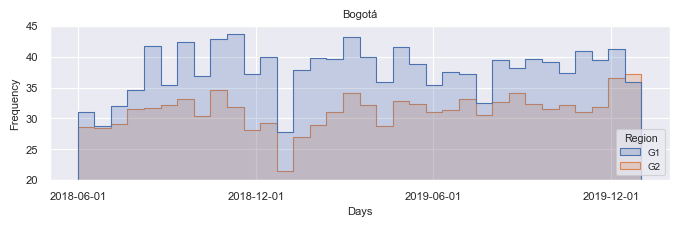

In [ ]:
# Import seaborn for enhanced statistical plotting.
import seaborn as sns
# Import matplotlib for plotting customization.
import matplotlib
# Create a figure with a specified size.
plt.figure(figsize=(10, 4))
# Apply seaborn's default theme.
sns.set_theme()

# Update matplotlib parameters, specifically setting the default font size.
matplotlib.rcParams.update({'font.size': 8})

# Set the seaborn context to 'paper' with a font scale.
sns.set_context("paper", font_scale=0.8)

# Define a color palette (tab10) and create a custom palette with two colors from it.
palette_tab10 = sns.color_palette("tab10", 10)
custom_palette = [palette_tab10[1], palette_tab10[0]] # Uses the second and first colors

# Create a figure and axes for the histogram plot.
fig, ax = plt.subplots(figsize=(8, 2))
# Create a histogram plot using seaborn's histplot.
# Data source is gdf_bog (assumed from previous cells).
# x='Times' plots frequency against the original timestamps.
# hue='Region' separates the data by the 'Region' column ('G1'/'G2').
# element="step" draws the histogram as steps.
# stat='frequency' plots the count of events in each bin.
# hue_order=['G1','G2'] specifies the order of hues.
# common_norm=False prevents normalization across hue categories.
# ax=ax specifies the axes to draw on.
sns.histplot(gdf_bog#.query("Region!=0") # Commented out query
             #, x="Times_simplyfied" # Commented out alternative x-axis
             , x='Times'
             , hue="Region"
             , element="step"
             , stat='frequency'
             #, palette=custom_palette # Commented out custom palette usage
             , hue_order=['G1','G2']
             , common_norm=False
             , ax=ax)

#plt.xticks(['2024-01-01', '2024-04-01', '2024-07-01', '2024-10-01']) # Commented out alternative x-ticks

# Set specific tick locations for the x-axis using dates.
plt.xticks(['2018-06-01', '2018-12-01', '2019-06-01', '2019-12-01'])
# Set the limits for the y-axis.
plt.ylim(20, 45)

# Move the legend to the lower right corner of the plot.
sns.move_legend(ax, "lower right")
# Set the main title of the plot.
plt.title("Bogotá", y=1.05) # y adjusts the title position

# Set title, axis labels, and tick label font size for the axes object.
ax.set_title('Bogotá', fontsize=8)          # Title of the plot
ax.set_xlabel('Days', fontsize=8)                     # X-axis label
ax.set_ylabel('Frequency', fontsize=8)                 # Y-axis label
ax.tick_params(axis='both', which='major', labelsize=8)  # Font size for axis ticks


# Save the figure to multiple file formats with specified resolution and bounding box.
# NOTE: Ensure the 'RESULTADOS/' directory exists before running this code.
plt.savefig('RESULTADOS/fig7a.svg',dpi=600,bbox_inches='tight')
plt.savefig('RESULTADOS/fig7a.png',dpi=600,bbox_inches='tight')
plt.savefig('RESULTADOS/fig7a.eps',dpi=600,bbox_inches='tight')
plt.savefig('RESULTADOS/fig7a.tiff',dpi=600,bbox_inches='tight')
# Display the plot.
plt.show()


In [25]:
#Fairness_table.query("Percentage==0.2").head()
Fairness_table.head()

,Unnamed: 0,Model,Percentage,Dia,Population,Confusion_Matrix,Precision,Accuracy,EMD
0,0,Naive,0.010,2018-02-01,Group 1,[[1 1]\n [0 0]],0.500000,0.500000,0.001926
1,1,Naive,0.010,2018-02-01,Group 2,[[1 0]\n [0 0]],1.000000,1.000000,0.001926
2,2,Naive,0.015,2018-02-01,Group 1,[[1 2]\n [0 0]],0.333333,0.333333,0.001926
3,3,Naive,0.015,2018-02-01,Group 2,[[2 0]\n [0 0]],1.000000,1.000000,0.001926
4,4,Naive,0.020,2018-02-01,Group 1,[[2 2]\n [0 0]],0.500000,0.500000,0.001926


### 11. Calculate Average Precision Differences by Region
This block loads the fairness results, standardizes the region names, and calculates the average precision for 'G1' (Unprotected) and 'G2' (Protected) regions for each model (Naive, KDE, SEPP) across different percentages of the predicted area (up to 30%). It then computes the average absolute difference in precision between the two regions for each model and prints these values along with the overall average difference.

In [ ]:
# Load the fairness results DataFrame from the TSV file.
# The path is relative to the current working directory.
Fairness_table=pd.read_csv('Fairness_Results_Bogota.tsv',sep='\t')
# Create a 'Region' column based on the 'Population' column, mapping 'Unprotected' to 'G1' and 'Protected' to 'G2'.
Fairness_table['Region']=Fairness_table.Population.apply(lambda x: 'G1' if x=="Unprotected" else 'G2')

# --- Calculate average precision for Naive model ---
# Filter for Naive model and G1 region with Percentage <= 0.3.
# Sort by Dia and Percentage, group by Percentage, and calculate the mean Precision.
percentage30naiveg1 = Fairness_table.query("(Percentage<=0.3) and (Model=='Naive') and (Region=='G1')").sort_values(by=['Dia','Percentage'],ascending=[True,True])
percentage30naiveg1=percentage30naiveg1[['Percentage','Precision']].groupby(by='Percentage').agg({'Precision':'mean'}).reset_index(drop=True)

# Filter for Naive model and G2 region with Percentage <= 0.3.
# Sort, group, and calculate mean Precision.
percentage30naiveg2 = Fairness_table.query("(Percentage<=0.3) and (Model=='Naive') and (Region=='G2')").sort_values(by=['Dia','Percentage'],ascending=[True,True])
percentage30naiveg2=percentage30naiveg2[['Percentage','Precision']].groupby(by='Percentage').agg({'Precision':'mean'}).reset_index(drop=True)

# --- Calculate average precision for KDE model ---
# Filter for KDE model and G1 region with Percentage <= 0.3.
# Sort, group, and calculate mean Precision.
percentage30KDEg1 = Fairness_table.query("(Percentage<=0.3) and (Model=='KDE') and (Region=='G1')").sort_values(by=['Dia','Percentage'],ascending=[True,True])
percentage30KDEg1=percentage30KDEg1[['Percentage','Precision']].groupby(by='Percentage').agg({'Precision':'mean'}).reset_index(drop=True)

# Filter for KDE model and G2 region with Percentage <= 0.3.
# Sort, group, and calculate mean Precision.
percentage30KDEg2 = Fairness_table.query("(Percentage<=0.3) and (Model=='KDE') and (Region=='G2')").sort_values(by=['Dia','Percentage'],ascending=[True,True])
percentage30KDEg2=percentage30KDEg2[['Percentage','Precision']].groupby(by='Percentage').agg({'Precision':'mean'}).reset_index(drop=True)

# --- Calculate average precision for SEPP model ---
# Filter for SEPP model and G1 region with Percentage <= 0.3.
# Sort, group, and calculate mean Precision.
percentage30SEPPg1 = Fairness_table.query("(Percentage<=0.3) and (Model=='SEPP') and (Region=='G1')").sort_values(by=['Dia','Percentage'],ascending=[True,True])
percentage30SEPPg1=percentage30SEPPg1[['Percentage','Precision']].groupby(by='Percentage').agg({'Precision':'mean'}).reset_index(drop=True)

# Filter for SEPP model and G2 region with Percentage <= 0.3.
# Sort, group, and calculate mean Precision.
percentage30SEPPg2 = Fairness_table.query("(Percentage<=0.3) and (Model=='SEPP') and (Region=='G2')").sort_values(by=['Dia','Percentage'],ascending=[True,True])
percentage30SEPPg2=percentage30SEPPg2[['Percentage','Precision']].groupby(by='Percentage').agg({'Precision':'mean'}).reset_index(drop=True)

#percentage30SEPPg2.head() # Commented out line

# Calculate the average absolute difference in Precision between G1 and G2 for each model.
avgnaive=np.average(np.abs(percentage30naiveg1.Precision.values-percentage30naiveg2.Precision.values))
avgkde=np.average(np.abs(percentage30KDEg1.Precision.values-percentage30KDEg2.Precision.values))
avgsepp=np.average(np.abs(percentage30SEPPg1.Precision.values-percentage30SEPPg2.Precision.values))

# Print the average differences for each model and the overall average difference.
print(avgnaive,avgkde,avgsepp,  (avgnaive+avgkde+avgsepp)/3)

# Calculate the maximum absolute difference in Precision across all models and percentages.
max(max(np.abs(percentage30naiveg1.Precision.values-percentage30naiveg2.Precision.values)),
    max(np.abs(percentage30KDEg1.Precision.values-percentage30KDEg2.Precision.values)),
    max(np.abs(percentage30SEPPg1.Precision.values-percentage30SEPPg2.Precision.values)))


0.0748505782726598 0.06903082032157716 0.06909955398669003 0.070993650860309


0.12790117750524993

### 12. Visualize Average Precision by Region and Percentage
This block uses the seaborn and matplotlib libraries to visualize the average precision of the Naive, KDE, and SEPP models across different percentages of the predicted area (up to 30%). The plot is faceted by model and uses color to distinguish between 'G1' (Unprotected) and 'G2' (Protected) regions. The plot is customized with specific formatting and labels and saved to multiple image file formats.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


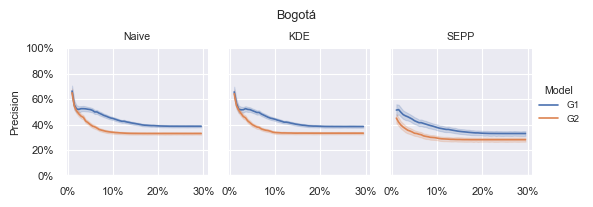

In [ ]:
# Import seaborn for enhanced statistical plotting.
import seaborn as sns
# Import matplotlib for plotting customization.
import matplotlib
# Update matplotlib parameters, setting the default font size for general text.
matplotlib.rcParams.update({'font.size': 10})

# Import specific matplotlib ticker formatters (not used in final code, but kept from original).
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import PercentFormatter

# Apply seaborn's default theme.
sns.set_theme()
# Load the fairness results DataFrame from the TSV file.
# The path is relative to the current working directory.
Fairness_table=pd.read_csv('Fairness_Results_Bogota.tsv',sep='\t')
# Create a 'Region' column based on the 'Population' column, mapping 'Unprotected' to 'G1' and 'Protected' to 'G2'.
Fairness_table['Region']=Fairness_table.Population.apply(lambda x: 'G1' if x=="Unprotected" else 'G2')

# Filter the DataFrame to include only rows where 'Percentage' is less than or equal to 0.3.
percentage30 = Fairness_table.query("Percentage<=0.3")

# Update matplotlib parameters, setting the default font size for plot elements.
matplotlib.rcParams.update({'font.size': 25})
# Set the seaborn context to 'paper' with a font scale.
sns.set_context("paper", font_scale=0.8)
# Define facet keyword arguments for shared y-axes across subplots.
facet_kws = {'sharey': True}

# Create a relational plot using seaborn's relplot.
# Data source is the filtered Fairness_table (Percentage <= 0.3).
# x="Percentage" maps the percentage of area to the x-axis.
# y="Precision" maps the precision value to the y-axis.
# hue="Region" colors the lines based on the 'Region' column ('G1'/'G2').
# hue_order=['G1','G2'] specifies the order of hues in the legend.
# kind="line" specifies a line plot.
# col="Model" creates separate columns (facets) for each model (Naive, KDE, SEPP).
# height=5 sets the height of each facet.
# aspect=0.3 sets the aspect ratio of each facet.
# facet_kws=facet_kws applies the shared y-axis setting.
# legend='brief' shows a brief legend.
g=sns.relplot(data=Fairness_table.query("Percentage<=0.3") # Data source and filtering
            ,x="Percentage"
            ,y="Precision"
            ,hue="Region"
            ,hue_order=['G1','G2']
            ,kind="line"
            ,col="Model"
            ,height=5
            ,aspect=0.3
            ,facet_kws=facet_kws
            ,legend='brief')

# Customize tick parameters for the x and y axes of all facets.
g.tick_params(axis='x', labelsize=8)
g.tick_params(axis='y', labelsize=8)
# Set the titles for each column (facet) using the model name.
g.set_titles(col_template="{col_name}")
# Set the axis labels for all facets.
g.set_axis_labels("", "Precision",size=8) # Empty string for x-axis label on facets
# Set the main title for the entire figure.
g.fig.suptitle("Bogotá", y=1.2) # y adjusts the title position

# Adjust the overall figure size.
g.fig.set_size_inches(6, 1.5)
# Move the legend to a specific position outside the plot area.
sns.move_legend(g, "upper left", bbox_to_anchor=(0.89, .75), title='Model')

# Access the individual axes objects within the figure.
axes = g.axes.flatten()
# Customize each subplot's y-axis limits and formatter.
axes[0].set_ylim(0, 1) # Set y-axis limits for the first subplot
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) # Format x-axis as percentage
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) # Format y-axis as percentage

axes[1].set_ylim(0, 1) # Set y-axis limits for the second subplot
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) # Format x-axis as percentage
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) # Format y-axis as percentage

axes[2].set_ylim(0, 1) # Set y-axis limits for the third subplot
axes[2].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) # Format x-axis as percentage
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x))) # Format y-axis as percentage

# Save the figure to multiple file formats with specified resolution and bounding box.
# NOTE: Ensure the 'RESULTADOS/' directory exists before running this code.
plt.savefig('RESULTADOS/fig5a.svg',dpi=600,bbox_inches='tight')
plt.savefig('RESULTADOS/fig5a.png',dpi=600,bbox_inches='tight')
plt.savefig('RESULTADOS/fig5a.eps',dpi=600,bbox_inches='tight')
plt.savefig('RESULTADOS/fig5a.tiff',dpi=600,bbox_inches='tight')
# Display the plot.
plt.show()


In [ ]:
Fairness_table.query("Percentage>=0.05").sort_values(by='Precision',ascending=False).head(10)

,Unnamed: 0,Model,Percentage,Dia,Population,Confusion_Matrix,Precision,Accuracy,EMD
12431,12431,SEPP,0.055,2019-02-05 00:00:00,Unprotected,[[10 0]\n [ 0 0]],1.000000,1.000000,0.001676
12433,12433,SEPP,0.060,2019-02-05 00:00:00,Unprotected,[[11 0]\n [ 0 0]],1.000000,1.000000,0.001676
12435,12435,SEPP,0.065,2019-02-05 00:00:00,Unprotected,[[11 0]\n [ 0 0]],1.000000,1.000000,0.001676
12437,12437,SEPP,0.070,2019-02-05 00:00:00,Unprotected,[[12 0]\n [ 0 0]],1.000000,1.000000,0.001676
40619,40619,SEPP,0.055,2019-04-27 00:00:00,Unprotected,[[10 0]\n [ 0 0]],1.000000,1.000000,0.001405
12439,12439,SEPP,0.075,2019-02-05 00:00:00,Unprotected,[[12 1]\n [ 0 0]],0.923077,0.923077,0.001676
77167,77167,SEPP,0.075,2019-08-10 00:00:00,Unprotected,[[12 1]\n [ 0 0]],0.923077,0.923077,0.001529
77165,77165,SEPP,0.070,2019-08-10 00:00:00,Unprotected,[[11 1]\n [ 0 0]],0.916667,0.916667,0.001529
82733,82733,SEPP,0.070,2019-08-26 00:00:00,Unprotected,[[11 1]\n [ 0 0]],0.916667,0.916667,0.001693
47929,47929,SEPP,0.060,2019-05-18 00:00:00,Unprotected,[[10 1]\n [ 0 0]],0.909091,0.909091,0.001676
